In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/DS:Deep Learning in Python/NN -Fundamental concepts from scratch')

Reading in and transforming data
epoch: 0 n_batches: 410
i: 0 j: 0 nb: 410 cost: 3.4789686 error rate: 0.92
i: 0 j: 50 nb: 410 cost: 2.060212 error rate: 0.619
i: 0 j: 100 nb: 410 cost: 0.7856274 error rate: 0.169
i: 0 j: 150 nb: 410 cost: 0.5130367 error rate: 0.104
i: 0 j: 200 nb: 410 cost: 0.3696076 error rate: 0.091
i: 0 j: 250 nb: 410 cost: 0.35043624 error rate: 0.081
i: 0 j: 300 nb: 410 cost: 0.26105028 error rate: 0.078
i: 0 j: 350 nb: 410 cost: 0.26058137 error rate: 0.069
i: 0 j: 400 nb: 410 cost: 0.26415175 error rate: 0.064
epoch: 1 n_batches: 410
i: 1 j: 0 nb: 410 cost: 0.27080604 error rate: 0.063
i: 1 j: 50 nb: 410 cost: 0.24804135 error rate: 0.064
i: 1 j: 100 nb: 410 cost: 0.2683737 error rate: 0.063
i: 1 j: 150 nb: 410 cost: 0.19571424 error rate: 0.062
i: 1 j: 200 nb: 410 cost: 0.18091302 error rate: 0.058
i: 1 j: 250 nb: 410 cost: 0.21584198 error rate: 0.056
i: 1 j: 300 nb: 410 cost: 0.24306288 error rate: 0.052
i: 1 j: 350 nb: 410 cost: 0.21338317 error rate: 0.04

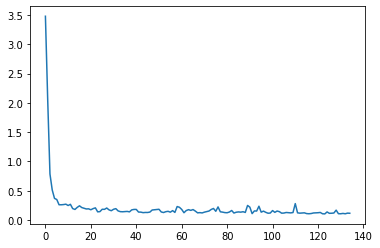

In [4]:
from __future__ import print_function, division
from builtins import range

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from util import get_normalized_data
#from sklearn.utils import shuffle

class HiddenLayer(object):
    def __init__(self, M1, M2):
        self.M1 = M1
        self.M2 = M2
        W = np.random.randn(M1, M2) * np.sqrt(2.0 / M1)
        b = np.zeros(M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]

    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)


class ANN(object):
    def __init__(self, hidden_layer_sizes, p_keep):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.dropout_rates = p_keep

    def fit(self, X, Y, Xvalid, Yvalid, lr=1e-4, mu=0.9, decay=0.9, epochs=15, batch_sz=100, print_every=50):
        X = X.astype(np.float32)
        Y = Y.astype(np.int64)
        Xvalid = Xvalid.astype(np.float32)
        Yvalid = Yvalid.astype(np.int64)

        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2)
            self.hidden_layers.append(h)
            M1 = M2
        W = np.random.randn(M1, K) * np.sqrt(2.0 / M1)
        b = np.zeros(K)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # set up theano functions and variables
        inputs = tf.placeholder(tf.float32, shape=(None, D), name='inputs')
        labels = tf.placeholder(tf.int64, shape=(None,), name='labels')
        logits = self.forward(inputs)

        cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits,
                labels=labels
            )
        )
        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)
        # train_op = tf.train.MomentumOptimizer(lr, momentum=mu).minimize(cost)
        # train_op = tf.train.AdamOptimizer(lr).minimize(cost)
        prediction = self.predict(inputs)

        # validation cost will be calculated separately since nothing will be dropped
        test_logits = self.forward_test(inputs)
        test_cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=test_logits,
                labels=labels
            )
        )

        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                print("epoch:", i, "n_batches:", n_batches)
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={inputs: Xbatch, labels: Ybatch})

                    if j % print_every == 0:
                        c = session.run(test_cost, feed_dict={inputs: Xvalid, labels: Yvalid})
                        p = session.run(prediction, feed_dict={inputs: Xvalid})
                        costs.append(c)
                        e = error_rate(Yvalid, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        plt.plot(costs)
        plt.show()

    def forward(self, X):
        # tf.nn.dropout scales inputs by 1/p_keep
        # therefore, during test time, we don't have to scale anything
        Z = X
        Z = tf.nn.dropout(Z, self.dropout_rates[0])
        for h, p in zip(self.hidden_layers, self.dropout_rates[1:]):
            Z = h.forward(Z)
            Z = tf.nn.dropout(Z, p)
        return tf.matmul(Z, self.W) + self.b

    def forward_test(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        pY = self.forward_test(X)
        return tf.argmax(pY, 1)


def error_rate(p, t):
    return np.mean(p != t)


def relu(a):
    return a * (a > 0)


def main():
    # step 1: get the data and define all the usual variables
    Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()

    ann = ANN([500, 300], [0.8, 0.5, 0.5])
    ann.fit(Xtrain, Ytrain, Xtest, Ytest)


if __name__ == '__main__':
    main()